In [1]:
import os
import sys
basepath = '/' + os.path.join('Users', 'zach', 'Git', 'Masterarbeit', 'Project')
sys.path.append(basepath)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Enable full width output for numpy (https://stackoverflow.com/questions/43514106/python-terminal-output-width)
np.set_printoptions(suppress=True, linewidth=250, threshold=250)

from src.ml.training import load_model
from sklearn.pipeline import Pipeline
from src.d.transformators import TransformData, FindGradient, FindAngle, Rotate, CDS, HF, TwoLayers, Shift
from data.fortran_test.utils import get_predictions, plot_vofs, create_plot
from src.ml.building import custom_loss

Using TensorFlow backend.


In [33]:
from sklearn.pipeline import Pipeline
from src.d.transformators import TransformData, FindGradient, FindAngle, Rotate, CDS, HF, TwoLayers, Shift, Edge
import subprocess
import re

# Suppress tensorflow logging
import logging
import os
from itertools import product as itpd
from multiprocessing import Process

# import threading
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)


input_features = np.reshape(np.array(
[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.00333330, 0.01250, 0.01666670, 0.0166667],
  [0.0, 0.00333330, 0.02583330, 0.04750, 0.06916670, 0.11750, 0.20333330, 0.24583330, 0.2458333],
  [0.04583330, 0.1250, 0.34083330, 0.5550, 0.73583330, 0.86250, 0.92416670, 0.93333330, 0.9333333],
  [0.50583330, 0.79250, 0.93166670, 0.96416670, 0.98250, 0.9950, 1.0, 1.0, 1.0],
  [0.95250, 0.98916670, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]]

), (81, 1))
print(np.round(np.reshape(input_features, (9, 9)), 3))
input_label = np.reshape(0, (1, 1))
input_data = np.concatenate((input_label, input_features)).T;
input_data = np.concatenate((input_data, input_data), axis=0)
input_data = pd.DataFrame(input_data)

parameters = {'stencil_size': [9, 9], 'angle': False}
data_pipeline = Pipeline([
    ('transform', TransformData(parameters=parameters, reshape=False)),
    ('findgradient', FindGradient(parameters=parameters)),
    ('findangle', FindAngle(parameters=parameters)),
    ('shift', Shift(parameters=parameters)),  # Output: [labels, data, angle_matrix]
    ('rotate', Rotate(parameters=parameters)),  # Output: [labels, data, angle_matrix]    
    ('edge', Edge(parameters=parameters)),  # Output: [labels, data, angle_matrix]    
])
[lab, feat, ang] = data_pipeline.fit_transform(input_data)

# Aus Fastest
pipeline_output_x = np.reshape(np.array(
[[0.0, 0.0, 0.0, 0.0, 0.0, 0.958750, 1.0],
  [0.0, 0.0, 0.0, 0.0, 0.136250, 1.0, 1.0],
  [0.0, 0.0, 0.0, 0.0, 0.801250, 1.0, 1.0],
  [0.0, 0.0, 0.0, 0.0, 0.90250, 1.0, 1.0],
  [0.0, 0.0, 0.0, 0.0, 0.990, 1.0, 1.0],
  [0.0, 0.0, 0.0, 0.063750, 1.0, 1.0, 1.0],
  [0.0, 0.0, 0.0, 0.08958330, 1.0, 1.0, 1.0]]
), (49, 1)).T

pipeline_output_y = np.reshape(np.array(
 [[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0],
  [0.0, 0.0, 0.0, 0.0, 0.94791670, 1.0, 1.0],
  [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0],
  [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0],
  [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0],
  [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0]]
), (49, 1)).T

feat_fast = np.concatenate((pipeline_output_x, pipeline_output_y), axis=1)
feat_fast = np.concatenate((pipeline_output, pipeline_output), axis=0)

model = '_mlp_1000_200-150-120_9x9_rot_flp_cut_dshift1_shift1_bia_int2_edg_cls'
pred = get_predictions(feat, basepath=basepath, filename=model, custom_objects = {'custom_loss': custom_loss})
pred_fast = get_predictions(feat_fast, basepath=basepath, filename=model, custom_objects = {'custom_loss': custom_loss})

print(np.round(np.reshape(feat[0], (2, 7, 7)),3))
#print(pred[0]*0.5*128/0.075)
print(pred[0])
print(pred_fast[0])

[[0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.003 0.012 0.017 0.017]
 [0.    0.003 0.026 0.048 0.069 0.118 0.203 0.246 0.246]
 [0.046 0.125 0.341 0.555 0.736 0.862 0.924 0.933 0.933]
 [0.506 0.792 0.932 0.964 0.982 0.995 1.    1.    1.   ]
 [0.952 0.989 1.    1.    1.    1.    1.    1.    1.   ]
 [1.    1.    1.    1.    1.    1.    1.    1.    1.   ]]
[[[0.    0.    0.    0.    0.    0.959 1.   ]
  [0.    0.    0.    0.    0.136 1.    1.   ]
  [0.    0.    0.    0.    0.801 1.    1.   ]
  [0.    0.    0.    0.    0.902 1.    1.   ]
  [0.    0.    0.    0.    0.99  1.    1.   ]
  [0.    0.    0.    0.064 1.    1.    1.   ]
  [0.    0.    0.    0.09  1.    1.    1.   ]]

 [[0.    0.    0.    0.    0.    1.    1.   ]
  [0.    0.    0.    0.    0.    1.    1.   ]
  [0.    0.    0.    0.    0.948 1.    1.   ]
  [0.    0.    0.    0. 

c:
[[0.    0.003 0.03  0.173 0.596 0.964 1.   ]
 [0.    0.004 0.04  0.22  0.699 0.976 1.   ]
 [0.    0.006 0.052 0.264 0.771 0.983 1.   ]
 [0.001 0.008 0.064 0.3   0.816 0.988 1.   ]
 [0.001 0.009 0.069 0.316 0.832 0.989 1.   ]
 [0.001 0.009 0.069 0.316 0.832 0.989 1.   ]
 [0.001 0.008 0.064 0.3   0.816 0.988 1.   ]]

cm:
[[0.    0.    0.03  0.173 0.596 0.964 1.   ]
 [0.    0.    0.04  0.22  0.699 0.976 1.   ]
 [0.    0.006 0.052 0.264 0.771 0.983 1.   ]
 [0.    0.008 0.064 0.3   0.816 0.988 1.   ]
 [0.    0.009 0.069 0.316 0.832 0.989 1.   ]
 [0.    0.009 0.069 0.316 0.832 0.989 1.   ]
 [0.    0.008 0.064 0.3   0.816 0.988 1.   ]]


cm=Fortran gedreht
c_f=Hier gedreht
c=Urspruenglich




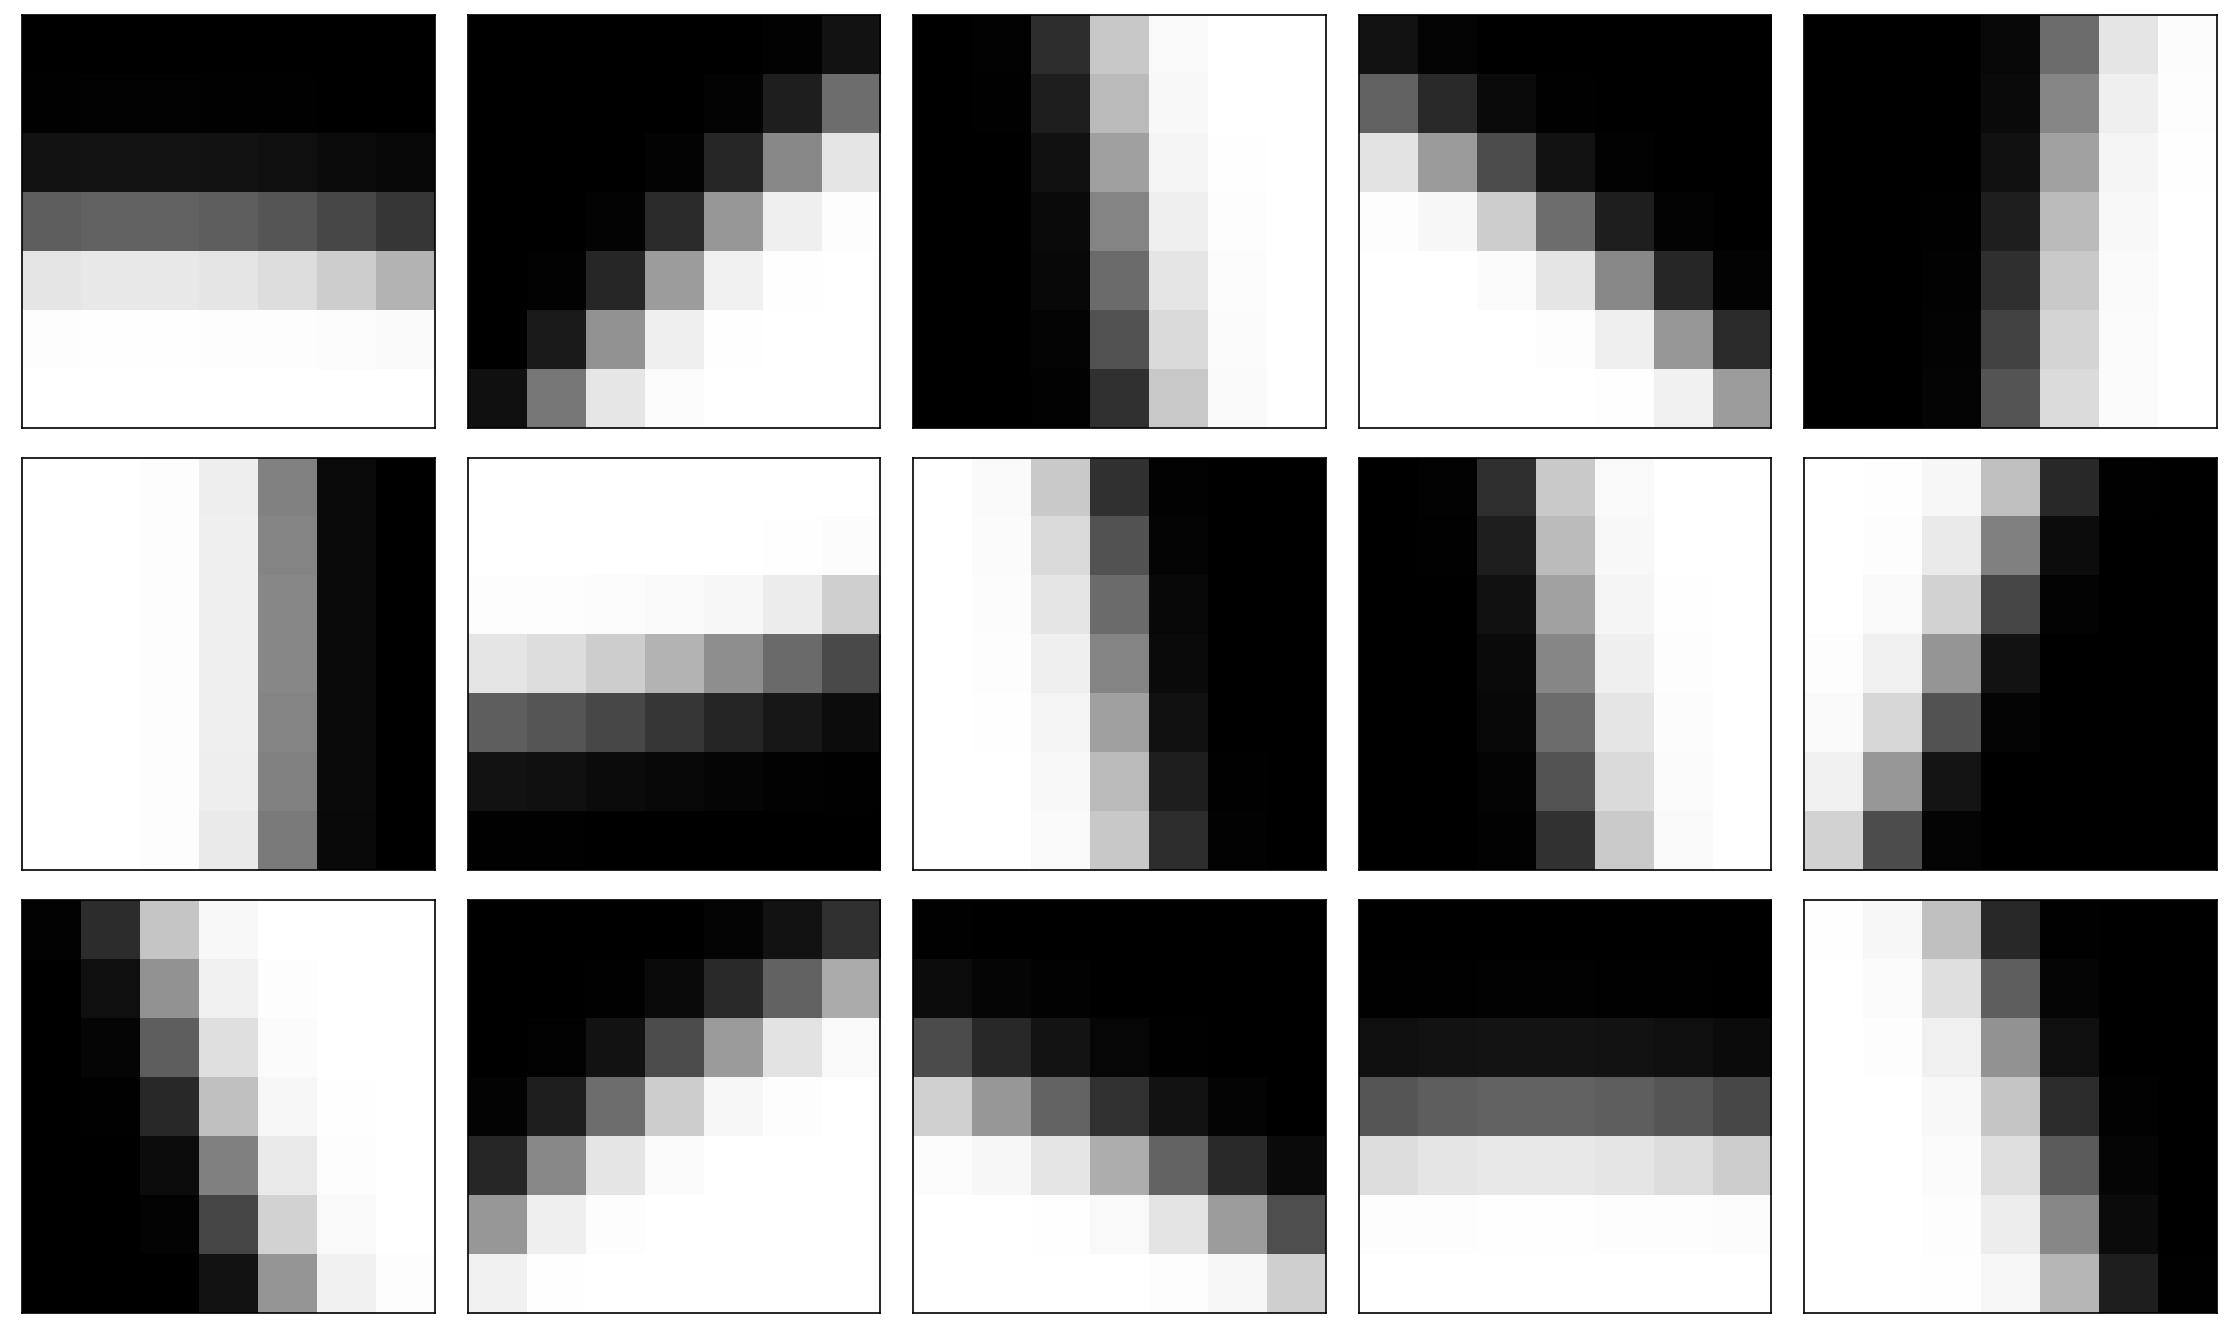

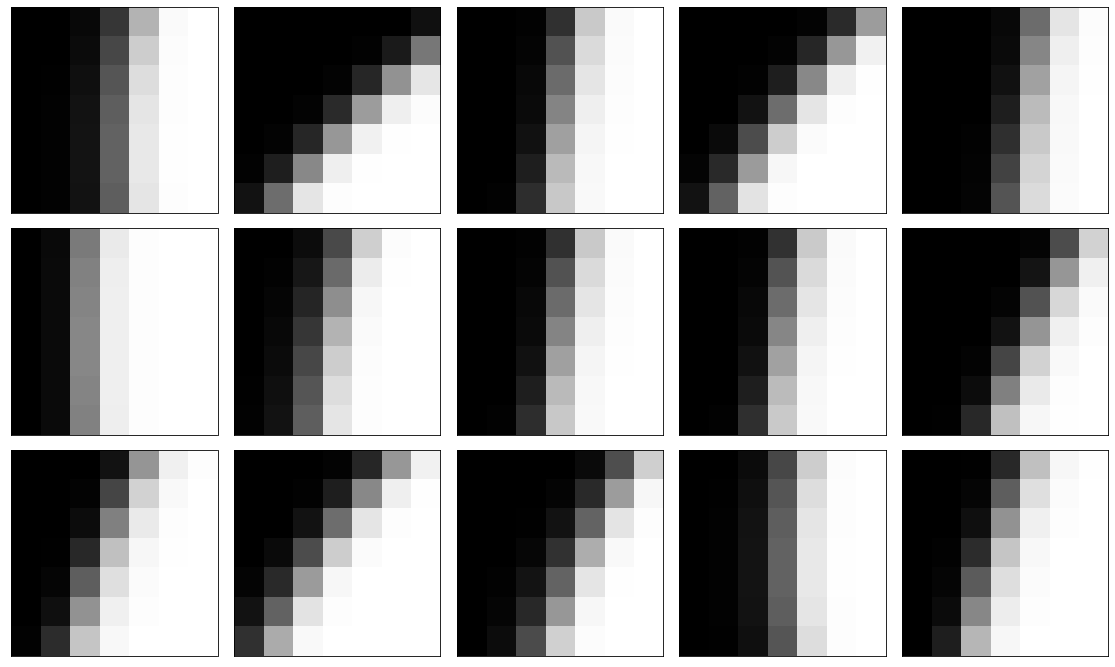

In [25]:
if False:
    print(vector_cm.shape)
    #indices = np.where((vector_last > 0.7) & (vector_last < 0.8))
    #indices = np.where((vector_last > vector_last.max()-vector_last.max()/10))
    indices = np.where((vector_last == 0))
    c = vector_c[indices[0], :]
    cm = vector_cm[indices[0], :]
    last = vector_last[indices]
    c_f = c_feat[indices]
    c_l = c_lab[indices]
    c_a = c_ang[indices]
    print(vector_cm.shape)
else:
    # Get random values
    np.random.seed(6) # fuer 1 Zeitschritt => ind = 4
    np.random.seed(2) # fuer 200 Zeitschritt => ind = 0
    indices = np.random.permutation(vector_c.shape[0])
    #indices = range(vector_c.shape[0])
    c = vector_c[indices, :]
    cm = vector_cm[indices, :]
    last = vector_last[indices]
    c_f = c_feat[indices]
    c_l = c_lab[indices]
    c_a = c_ang[indices]

'''
# Find stencils that could still be shifted
c_tmp = np.reshape(c_f, (c_f.shape[0], 7, 7))
c_tmp_sum = np.sum(c_tmp, axis=1)
#ind_tmp = np.where((c_tmp_sum[:, 0] < 0.02) & (c_tmp_sum[:, 0] > 0))
ind_tmp = np.where((c_tmp_sum[:, 6] > 7-0.02) & (c_tmp_sum[:, 6] < 7))

c_f = c_f[ind_tmp]
c_a = c_a[ind_tmp]

#cm[np.nonzero(cm < 0.02)] = 1
#c_f[np.nonzero(c_f < 0.02)] = 1
#c_f[np.nonzero(c_f > 0.99)] = 0
'''
ind = 0
print('c:')
print(np.rot90(np.round(np.reshape(c[ind], (7, 7)), 3)))
print('\ncm:')
#print(np.reshape(c[3], (7, 7)))
print(np.round(np.reshape(cm[ind], (7, 7)),3))
print('\n')
    
#cds = vector_cds
n_plots = 15
#plot_vofs(np.reshape(c, (c.shape[0],7,7)), 5, labels=last, per_row=5)
#plot_vofs(np.reshape(c_f, (c_f.shape[0],7,7)), 5, labels=c_l*faktor, per_row=5)
#plot_vofs(np.reshape(c_f, (c_f.shape[0],7,7)), 40, per_row = 5, size=0.5)
print('cm=Fortran gedreht\nc_f=Hier gedreht\nc=Urspruenglich')
#plot_vofs(np.reshape(cm, (cm.shape[0],7,7)), n_plots, labels=last, per_row=5)
#plot_vofs(np.reshape(c_f, (c_f.shape[0],7,7)), n_plots, labels=c_l*faktor, per_row = 5, size=0.5)
plot_vofs(np.reshape(c, (c.shape[0],7,7)), n_plots, per_row=5)
plot_vofs(np.reshape(cm, (c_f.shape[0],7,7)), n_plots, per_row = 5, size=0.5)


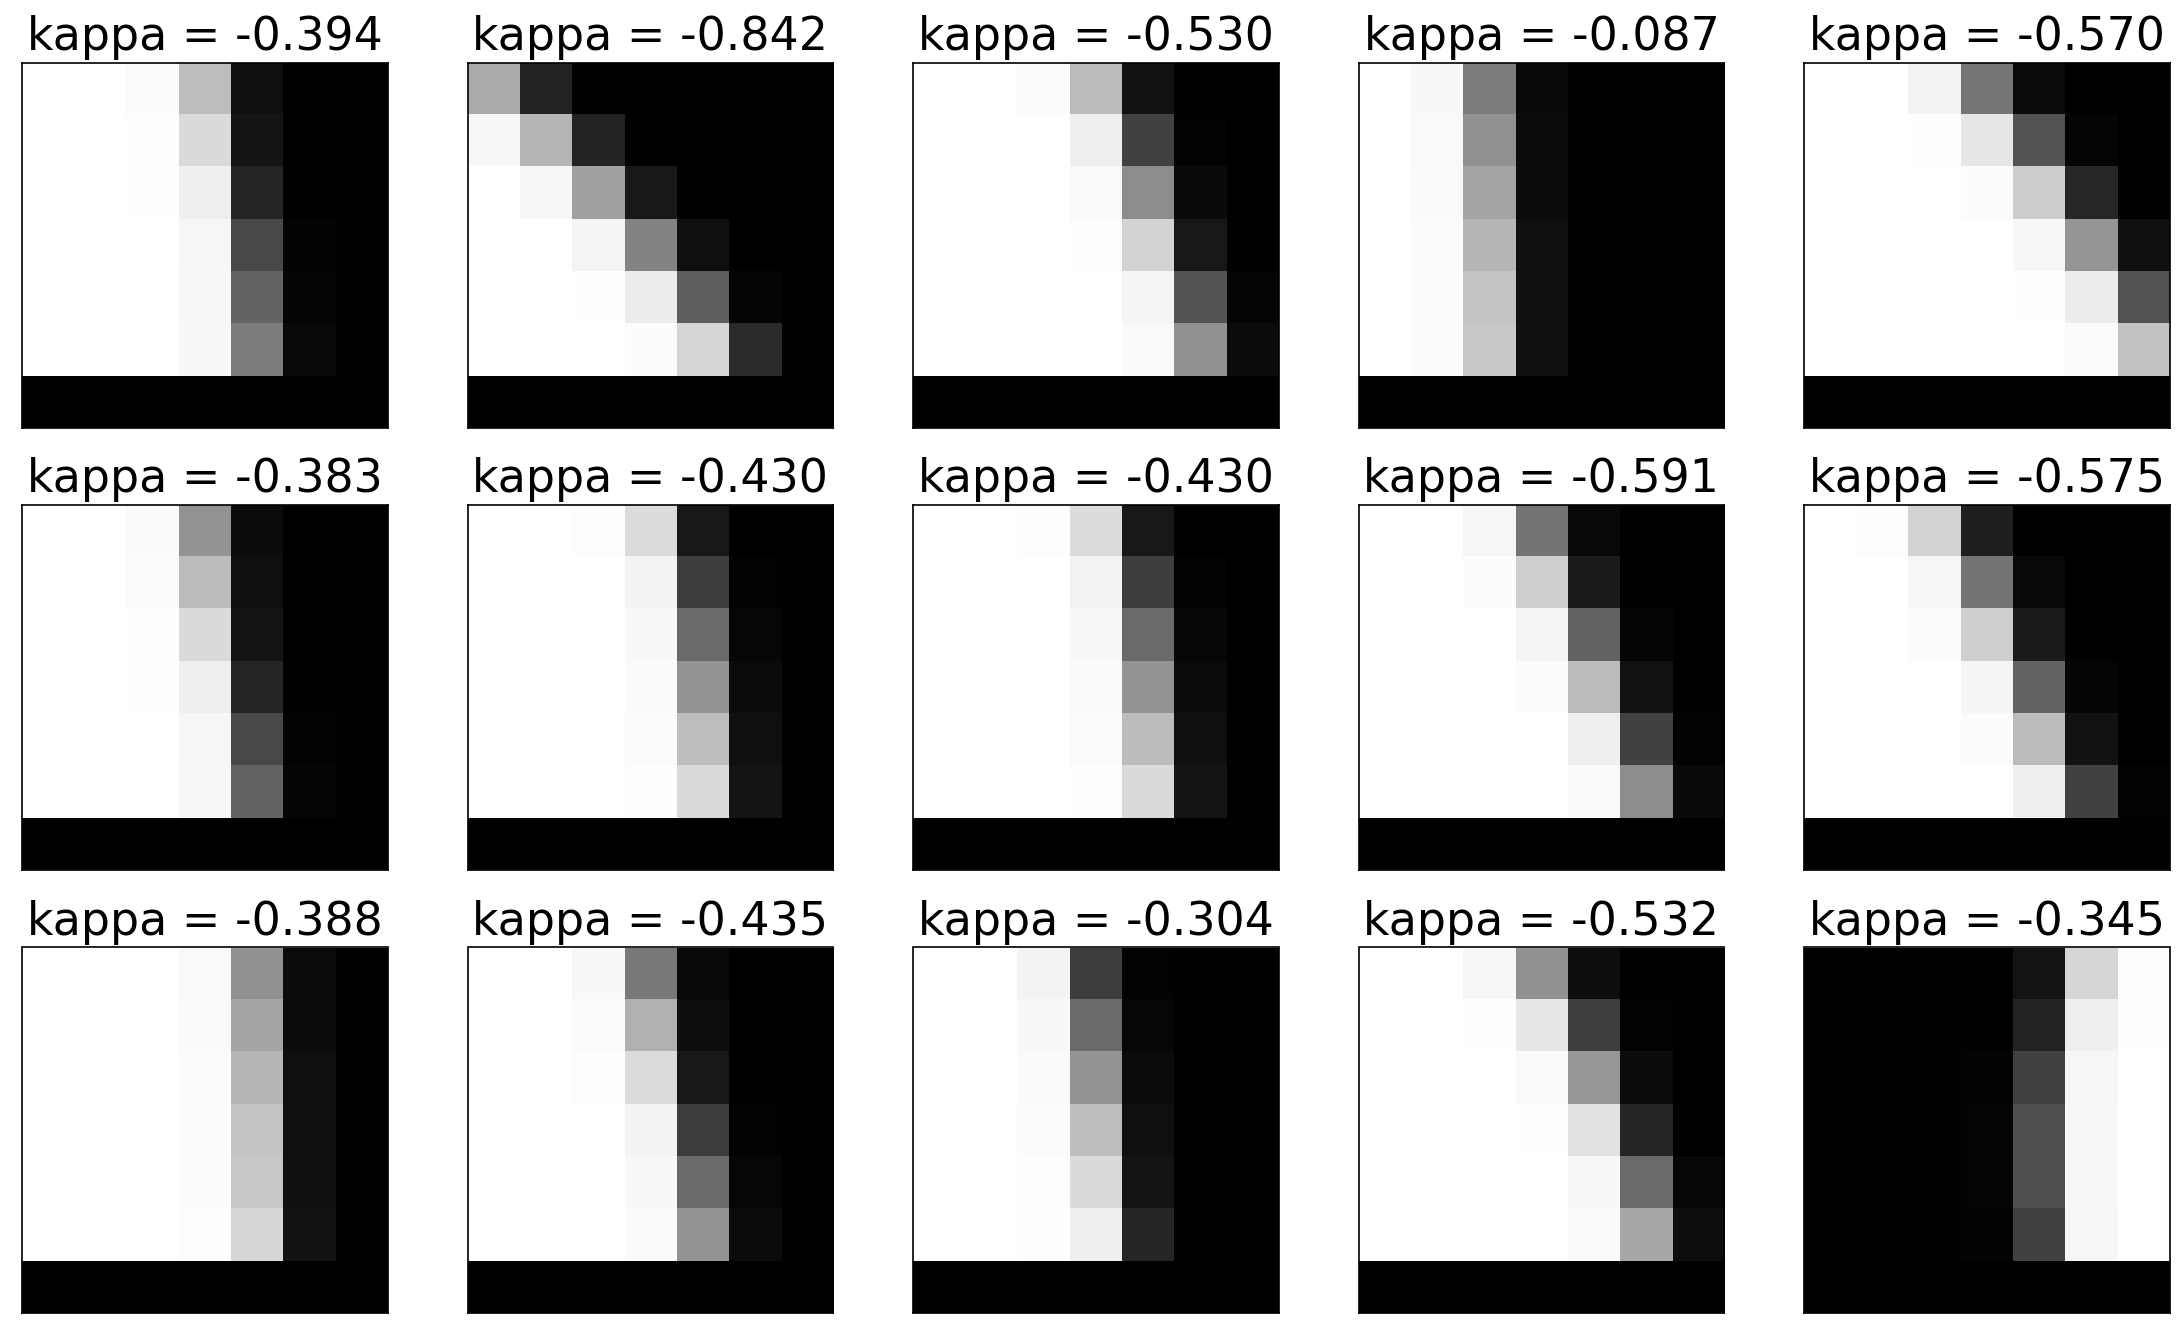

In [5]:
st_sz = [7, 7]
cm_tmp = np.reshape(cm, (cm.shape[0], st_sz[0], st_sz[1], 1))
result = cm_tmp.copy()
result[:, :st_sz[0]-1, :, :] = cm_tmp[:, 1:, :, :]
result[:, st_sz[0]-1, :, :] = 0
#result[:, :st_sz[0]-1, :, :] = result[:, 1:, :, :]
#result[:, st_sz[0]-1, :, :] = 0
result = np.reshape(result, (result.shape[0], st_sz[0]*st_sz[1]))

testmodel = '_mlp_1000_200-150-120_7x7_eqk_0.0001_128_relu_neg_nag_rot_all_smr_nhc_shift_kappa'
custom_object = {'custom_loss': custom_loss}
result_predictions = fortran_predictions = get_predictions(result, basepath=basepath, filename=testmodel, custom_objects=custom_object)#*faktor  # vector_last*faktor # 


plot_vofs(np.reshape(result, (result.shape[0],7,7)), 15, labels=result_predictions, per_row=5)


Mittelwert/Standardabweichung cm:	189.2621,	168.7466


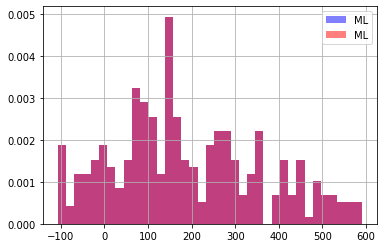

In [6]:
#dtm = 'circle'
#testmodel = '_mlp_1000_100-80_7x7_eqk_0.0001_128_relu_neg_nag_rot_'+dtm+'_smr_nhc' + '_shift_kappa'
testmodel = '_mlp_1000_200-150-120_7x7_eqk_0.0001_128_relu_neg_nag_rot_all_smr_nhc_shift_kappa'
#testmodel2 = '_mlp_1000_200-150-120_7x7_eqk_0.0001_128_relu_neg_nag_rot_all_smr_nhc_shift_kappa'
#testmodel = '_mlp_1000_100-80_7x7_eqk_0.0001_128_relu_neg_nag_rot_circle_smr_nhc_shift_kappa'
custom_object = {'custom_loss': custom_loss}

fortran_predictions = get_predictions(cm, basepath=basepath, filename=testmodel, custom_objects=custom_object)*faktor  # vector_last*faktor # 
#fortran_predictions_2 = get_predictions(cm, basepath=basepath, filename=testmodel2, custom_objects=custom_object)*faktor
idx = list(range(0,9))

print(f'\nMittelwert/Standardabweichung cm:\t{np.mean(fortran_predictions):.4f},\t{np.std(fortran_predictions):.4f}')
#print(f'Mittelwert/Standardabweichung c:\t{np.mean(fortran_predictions_2):.4f},\t{np.std(fortran_predictions_2):.4f}')
#print(f'Mittelwert/Standardabweichung cds:\t{np.mean(cds):.4f},\t{np.std(cds):.4f}')

roud = 3
#pd.Series(np.round(fortran_predictions, roud)).hist(bins=160, color='b', label='ML', alpha=0.5, density=True)

#pd.Series(np.round(cds, roud)).hist(bins=35, alpha=0.5, color='r', label='CDS', density=True)
pd.Series(np.round(last, roud)).hist(bins=37, color='b', label='ML', alpha=0.5, density=True)
pd.Series(np.round(fortran_predictions, roud)).hist(bins=37, color='r', label='ML', alpha=0.5, density=True)
#pd.Series(np.round(fortran_predictions_2, roud)).hist(bins=50, color='r', label='c', alpha=0.5, density=True)
#pd.Series(np.round(cds, roud)).hist(bins=30, alpha=0.5, color='r', label='CDS', density=True)


# Vergleich ml cds
# pd.Series(np.round(vector_last, roud)).hist(bins=50, alpha=1, color='b', label='ml')
# pd.Series(np.round(vector_cds, roud)).hist(bins=100, alpha=1, color='r', label='cds')
plt.legend()
x1,x2,y1,y2 = plt.axis()
#plt.axis((0.15,0.85,y1,y2))

#pd.Series(predictions_dg).hist(bins=50, alpha=0.5)

#ind = np.nonzero(fortran_predictions < 0.3)[0]
#test_features = cm[ind , :]
#plot_vofs(np.reshape(c_f, (c_f.shape[0],7,7)), 5, labels=fortran_predictions[ind], per_row=5)
#print(test_features.shape)

In [7]:
#a = np.array([[1, 2, 3],[4, 5, 6], [7, 8, 9]])
a = np.array([[7, 8, 9],[4, 5, 6], [1, 2, 3]])
b = a + 1

ar = np.zeros((4, 3, 3))
ar[0] = a
ar[1] = b
ar[2] = a
ar[3] = b
print('Vorher')
#print(np.flip(ar, axis=1))
print(ar)



ar = np.reshape(ar, (ar.shape[0], ar.shape[1], ar.shape[2], 1))
rot = np.argwhere(np.flip(ar, axis=1)[:, 0, 0, :] == 1)
#ar[rot] = np.transpose(np.rot90(ar[rot], 1, axes=(2, 3))[0], (0, 2, 1, 3))
ar[rot] = np.transpose(ar[rot][0], (0, 2, 1, 3))

#ar = np.reshape(ar, (ar.shape[0], ar.shape[1], ar.shape[2]))
#ar = np.flip(ar, axis=1)
ar = np.reshape(ar, (ar.shape[0], 3, 3))
print('\nNachher')
print(ar)

Vorher
[[[ 7.  8.  9.]
  [ 4.  5.  6.]
  [ 1.  2.  3.]]

 [[ 8.  9. 10.]
  [ 5.  6.  7.]
  [ 2.  3.  4.]]

 [[ 7.  8.  9.]
  [ 4.  5.  6.]
  [ 1.  2.  3.]]

 [[ 8.  9. 10.]
  [ 5.  6.  7.]
  [ 2.  3.  4.]]]

Nachher
[[[ 7.  4.  1.]
  [ 8.  5.  2.]
  [ 9.  6.  3.]]

 [[ 8.  9. 10.]
  [ 5.  6.  7.]
  [ 2.  3.  4.]]

 [[ 7.  4.  1.]
  [ 8.  5.  2.]
  [ 9.  6.  3.]]

 [[ 8.  9. 10.]
  [ 5.  6.  7.]
  [ 2.  3.  4.]]]
